# Decoder - 2 layers GRU

In [25]:
import os
import datetime

root = '/home/8B07/Raiso/230308-good-unit-decoder/'
dataset_folder = os.path.join(root, '1.datasets')

now = str(datetime.datetime.today()).split('.')[0].replace(':', '-').replace(' ', '-')
result = os.path.join(root, '3.results', now)
os.makedirs(result, exist_ok = True)

epochs = 10
batch = 64
ts = 10
feat_file = os.path.join(dataset_folder, 'LA.pickle')
tft_flie = os.path.join(dataset_folder, 'H2.npy')

In [2]:
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


In [3]:
feat = pickle.load(open(feat_file, 'rb'))
tgt = np.load(tft_flie)
feat = feat[:, mask]
tdim = feat.shape[0]
idim, odim = feat.shape[1], tgt.shape[1]
print(tdim, idim, odim)
print(mask)

184000 38 2


In [4]:
class Dateset(torch.utils.data.Dataset):
    def __init__(self, feat, tgt, ts):
        print(feat.shape, tgt.shape)
        self.feat = torch.Tensor(feat)
        self.tgt = torch.Tensor(tgt)
        self.tdim = tgt.shape[0]

    def __getitem__(self, i):
        return self.feat[i: i+ts], self.tgt[i+ts-1]

    def __len__(self):
        return self.tdim-ts+1

In [5]:
cut1 = int(0.7 * tdim)
cut2 = int(0.8 * tdim)

tr_set = Dateset(feat[:cut1], tgt[:cut1], ts)
dv_set = Dateset(feat[cut1:cut2], tgt[cut1:cut2], ts)
tt_set = Dateset(feat[cut2:], tgt[cut2:], ts)

del cut1, cut2
print('Shape: ', len(tr_set), len(dv_set), len(tt_set))

(128799, 38) (128799, 2)
(18401, 38) (18401, 2)
(36800, 38) (36800, 2)
Shape:  128790 18392 36791


In [6]:
tr_load = DataLoader(tr_set, batch, shuffle=True,
                    drop_last=False, pin_memory=True)  
dv_load = DataLoader(dv_set, batch, shuffle=False,
                    drop_last=False, pin_memory=True)  
tt_load = DataLoader(tt_set, batch, shuffle=False,
                    drop_last=False, pin_memory=True)  

In [7]:
class Decoder(nn.Module):
    def __init__(self, idim, odim, ts):
        super().__init__()
        self.gru1 = nn.GRU(idim, 256, num_layers=1, 
                           batch_first=True, bidirectional=True)
        self.gru2 = nn.GRU(2 * 256, 256, num_layers=1, 
                           batch_first=True, bidirectional=True)
        self.readout = nn.Sequential(
            nn.Linear(256 * 2 * ts, 64),
            nn.ReLU(),
            nn.Linear(64, odim),  
        )
        self.criterion = nn.MSELoss()
    
    def forward(self, x):
        bz, _, _ = x.size()
        x, _ = self.gru1(x)
        x = nn.functional.layer_norm(x, x.size()[-1:])
        x, _ = self.gru2(x)
        emb = nn.functional.layer_norm(x, x.size()[-1:]) 
        yh = self.readout(emb.reshape(bz, -1))
        return yh
   
    def cal_loss(self, yh, y):
        return self.criterion(yh, y)

model = Decoder(idim, odim, ts).to(device)
print(model)

Decoder(
  (gru1): GRU(38, 38, batch_first=True, bidirectional=True)
  (gru2): GRU(76, 256, batch_first=True, bidirectional=True)
  (readout): Sequential(
    (0): Linear(in_features=5120, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
  (criterion): MSELoss()
)


# Training

In [8]:
begin = time.time()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
tr_loss = []
dv_loss = []
mini_dv_loss = 2e9

for e in tqdm(range(epochs)):
    model.train()
    for x, y in tr_load:
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        yh = model(x) 
        loss = model.cal_loss(yh, y)
        loss.backward()
        optimizer.step()
        tr_loss.append(loss.detach().cpu().item())

    model.eval() 
    ave_dv_loss = 0
    for x, y in dv_load:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            yh = model(x) 
            loss = model.cal_loss(yh, y)
        ave_dv_loss += loss.detach().cpu().item() * len(x)  # accumulate loss
    ave_dv_loss = ave_dv_loss / len(dv_load.dataset)
    dv_loss.append(ave_dv_loss)
    
    if ave_dv_loss < mini_dv_loss:
        mini_dv_loss = ave_dv_loss
        # print('Saving model (epoch = {:4d}, loss = {:.4f})'.format(e + 1, ave_dv_loss))
        torch.save(model.state_dict(), os.path.join(result, 'best.pt'))

print(f'time cost: {time.time() - begin}')
torch.save(model.state_dict(), os.path.join(result, 'last.pt'))

100%|██████████████████████████████████████████████████████████████████████| 10/10 [02:15<00:00, 13.60s/it]

time cost: 136.00087761878967


# Testing

In [10]:
del model
model = Decoder(idim, odim, ts).to(device)
ckpt = torch.load('best_model.pt', map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)

<All keys matched successfully>

In [11]:
model.eval()               # set model to evalutation mode
pred, real = np.zeros((0, odim)), np.zeros((0, odim))
for x, y in tt_load:                           # iterate through the dataloader
    x = x.to(device)                        # move data to device (cpu/cuda)
    with torch.no_grad():                   # disable gradient calculation
        yh = model(x)                     # forward pass (compute output)
        pred = np.concatenate((pred, yh.detach().cpu().numpy()))
    real = np.concatenate((real, y.detach().numpy()))

In [27]:
np.save(os.path.join(result, 'pred.npy'), pred)

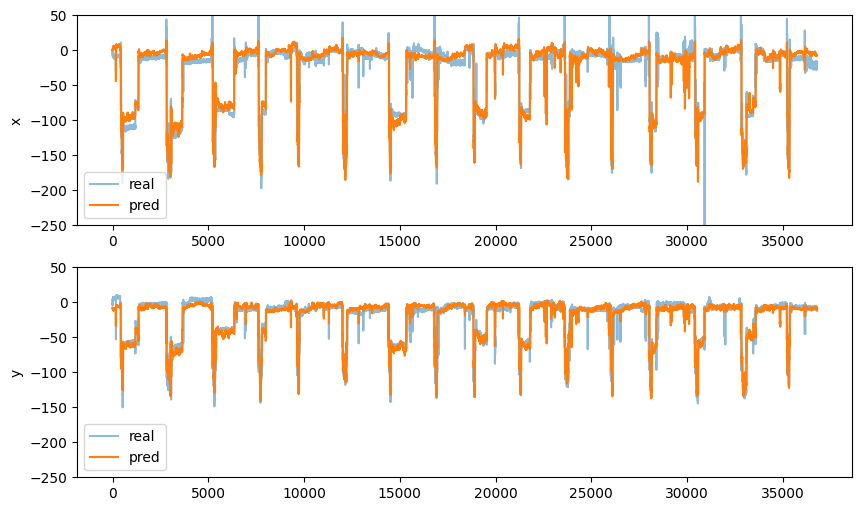

In [26]:
plt.figure(figsize = (10, 6))
plt.subplot(2,1,1)
plt.plot(real[:,0], alpha=0.5, label='real')
plt.plot(pred[:,0], label='pred')
plt.ylabel('x')
plt.ylim([-250, 50])
plt.legend()
plt.subplot(2,1,2)
plt.plot(real[:,1], alpha=0.5, label='real')
plt.plot(pred[:,1], label='pred')
plt.ylabel('y')
plt.ylim([-250, 50])
plt.legend()
plt.savefig(os.path.join(result, 'traces.png'))
# plt.show()

In [29]:
r2 = r2_score(real, pred)
print(r2)

f = open(os.path.join(result, 'r2.txt'), 'w')
f.write(str(r2))
f.close()

0.9436426600154839


In [31]:
np.save(os.path.join(result, 'tr_loss.npy'), tr_loss)
np.save(os.path.join(result, 'dv_loss.npy'), dv_loss)